In [5]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

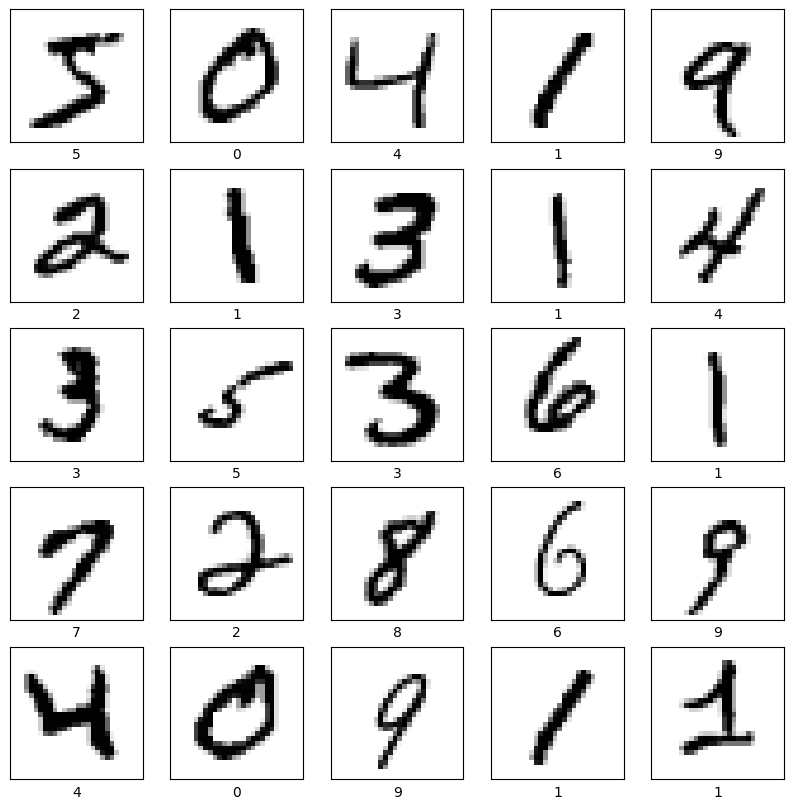

In [6]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Function to plot images
def plot_mnist_images(images, labels, num_images):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(labels[i])
    plt.show()

# Plot the first 25 images from the training set
plot_mnist_images(x_train, y_train, 25)

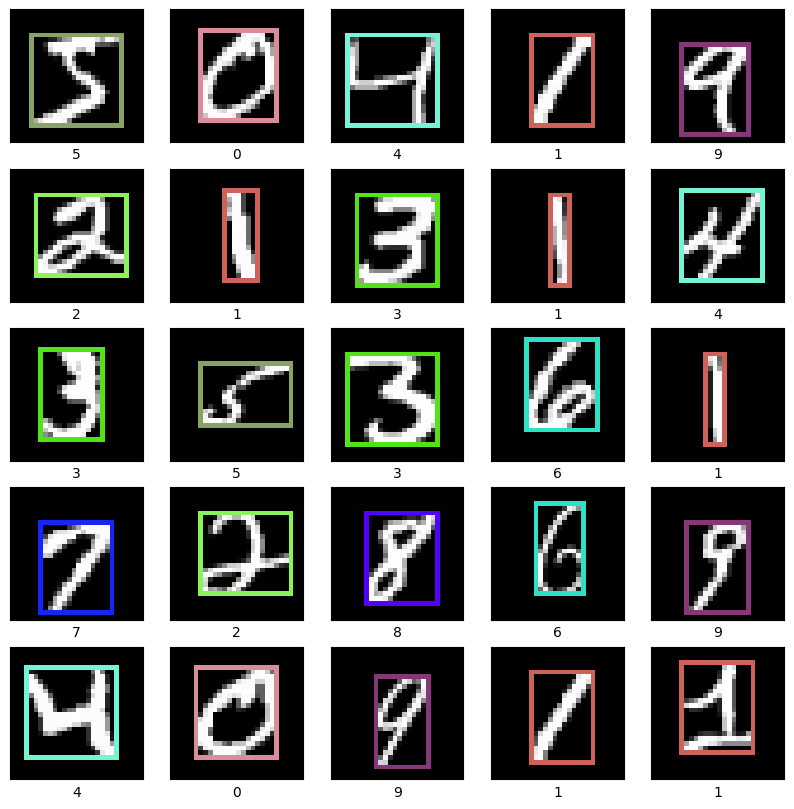

In [44]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random

# Load the MNIST dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

def generate_random_rgb():
    return (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

rgb_dict_with_function = {i: generate_random_rgb() for i in range(10)}


# Function to draw bounding box around the digit and return normalized coordinates
def draw_bounding_box(image, label, label_color_map):
    # Find the non-zero pixels
    coords = np.column_stack(np.where(image > 0))
    # Find the bounding box
    x_min, y_min = coords.min(axis=0)
    x_max, y_max = coords.max(axis=0)
    # Draw the bounding box
    image_with_bbox = np.stack([image, image, image], axis=-1)  # Convert to RGB
    image_with_bbox = cv2.rectangle(image_with_bbox, (y_min, x_min), (y_max, x_max), color=label_color_map[label], thickness=1)
    # Calculate normalized coordinates
    norm_coords = (x_min / image.shape[0], y_min / image.shape[1], x_max / image.shape[0], y_max / image.shape[1])
    return image_with_bbox, norm_coords

# Function to plot images with bounding boxes and display normalized coordinates
def plot_mnist_images_with_bbox(images, labels, label_color_map, num_images):
    norm_coords_list = []
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        image_with_bbox, norm_coords = draw_bounding_box(images[i], labels[i], label_color_map)
        norm_coords_list.append(norm_coords)
        plt.imshow(image_with_bbox)
        plt.xlabel(labels[i])
    plt.show()
    return norm_coords_list

# Plot the first 25 images with bounding boxes from the training set and get normalized coordinates
normalized_coordinates = plot_mnist_images_with_bbox(x_train, y_train, rgb_dict_with_function, 25)


In [46]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random

# Load the MNIST dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

def generate_random_rgb():
    return (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
rgb_dict_with_function = {i: generate_random_rgb() for i in range(10)}

NameError: name 'vcxv' is not defined

In [28]:
np.where(x_train[0])

AttributeError: 'tuple' object has no attribute 'shape'

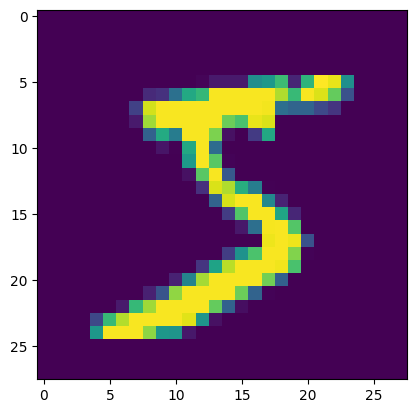

In [41]:
plt.imshow(x_train[0])

In [31]:
166/28

5.928571428571429

In [37]:
np.where(x_train[0])

(array([ 5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10,
        10, 11, 11, 11, 11, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 14, 14,
        14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 17, 17,
        17, 17, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19,
        20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21,
        21, 21, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23,
        23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24, 24], dtype=int64),
 array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,  8,  9, 10, 11, 12,
        13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,  7,  8,  9, 10, 11, 12,
        13, 14, 15, 16, 17, 18, 19, 20, 21, 22,  7,  8,  9, 10, 11, 12, 13,
        14, 1